In [47]:
"""
Author: Hayden Hedman
Date: August 2025

Project: Engagement Lift Analysis
Module: 03_pretrend_balance_checks.ipynb

Purpose:
--------
Formally assess pre-treatment balance between treatment and control groups.
Critically, the pre-period here is defined as dates strictly before the product
rollout date used in the simulation (ROLL_OUT_DATE), so any injected pre-period
bias will be visible in both plots and models.
"""

'\nAuthor: Hayden Hedman\nDate: August 2025\n\nProject: Engagement Lift Analysis\nModule: 03_pretrend_balance_checks.ipynb\n\nPurpose:\n--------\nFormally assess pre-treatment balance between treatment and control groups.\nCritically, the pre-period here is defined as dates strictly before the product\nrollout date used in the simulation (ROLL_OUT_DATE), so any injected pre-period\nbias will be visible in both plots and models.\n'

In [48]:
# Load libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.formula.api as smf
from datetime import datetime

In [49]:
# determine plot design components
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams.update({
    "figure.figsize": (11, 6),
    "lines.linewidth": 2.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Load data basic data cleaning
def _maybe_load_from_memory():
    # Accept either (users_df, timeseries_df) or (users, timeseries)
    g = globals()
    if "users_df" in g and "timeseries_df" in g:
        u, ts = g["users_df"].copy(), g["timeseries_df"].copy()
        return u, ts
    if "users" in g and "timeseries" in g:
        u, ts = g["users"].copy(), g["timeseries"].copy()
        return u, ts
    return None, None

users, timeseries = _maybe_load_from_memory()
if users is None or timeseries is None:
    # Try disk (your Script 01 saves here)
    base = "../data/raw"
    users_path = os.path.join(base, "users.csv")
    ts_path = os.path.join(base, "user_timeseries.csv")
    if not (os.path.exists(users_path) and os.path.exists(ts_path)):
        raise FileNotFoundError(
            "Could not find users/timeseries in memory or ../data/raw/. "
            "Run 01_data_simulation.ipynb first."
        )
    users = pd.read_csv(users_path, parse_dates=["signup_date"])
    timeseries = pd.read_csv(ts_path, parse_dates=["date"])

# Standardize column names
if "minutes_engaged" in timeseries.columns and "engagement" not in timeseries.columns:
    timeseries = timeseries.rename(columns={"minutes_engaged": "engagement"})

if "new_rec_engine" not in users.columns:
    raise KeyError("Expected 'new_rec_engine' flag in users dataframe.")

# Ensure types
users["new_rec_engine"] = users["new_rec_engine"].astype(int)

In [50]:
# Determine ROLL_OUT_DATE coherently with your sim
# If you've defined ROLL_OUT_DATE in this kernel, we use it.
if "ROLL_OUT_DATE" in globals():
    rollout_date = pd.to_datetime(globals()["ROLL_OUT_DATE"])
else:
    # Infer a reasonable rollout date from the data year:
    # Use June 1st of the min year found in timeseries dates.
    yr = int(timeseries["date"].dt.year.min())
    rollout_date = pd.to_datetime(f"{yr}-06-01")

In [51]:
# Merge and slice PRE period correctly (date < ROLL_OUT_DATE) ---
merged = timeseries.merge(users, on="user_id", how="inner")
pre = merged[merged["date"] < rollout_date].copy()

if pre.empty:
    # If still empty (e.g., all data post-rollout), fallback to a percentile cutoff
    cutoff = merged["date"].quantile(0.3)
    pre = merged[merged["date"] < cutoff].copy()
    print(f"WARNING: No rows before inferred rollout; falling back to date<{cutoff.date()}")

# Create a per-user time index for plotting (days since each user's first obs)
pre = pre.sort_values(["user_id", "date"])
pre["time_idx"] = pre.groupby("user_id").cumcount()


In [52]:
# Quick diagnostics ---
print(f"Pre-period rows retained: {len(pre):,}")
print("Treatment values present in pre-period:", pre["new_rec_engine"].unique())

# If either group is missing, warn and stop early
if set(pre["new_rec_engine"].unique()) - {0,1} or pre["new_rec_engine"].nunique() < 2:
    raise ValueError(
        "Pre-period contains <2 treatment groups. "
        "Check simulation dates vs rollout date."
    )

Pre-period rows retained: 45,060
Treatment values present in pre-period: [0 1]


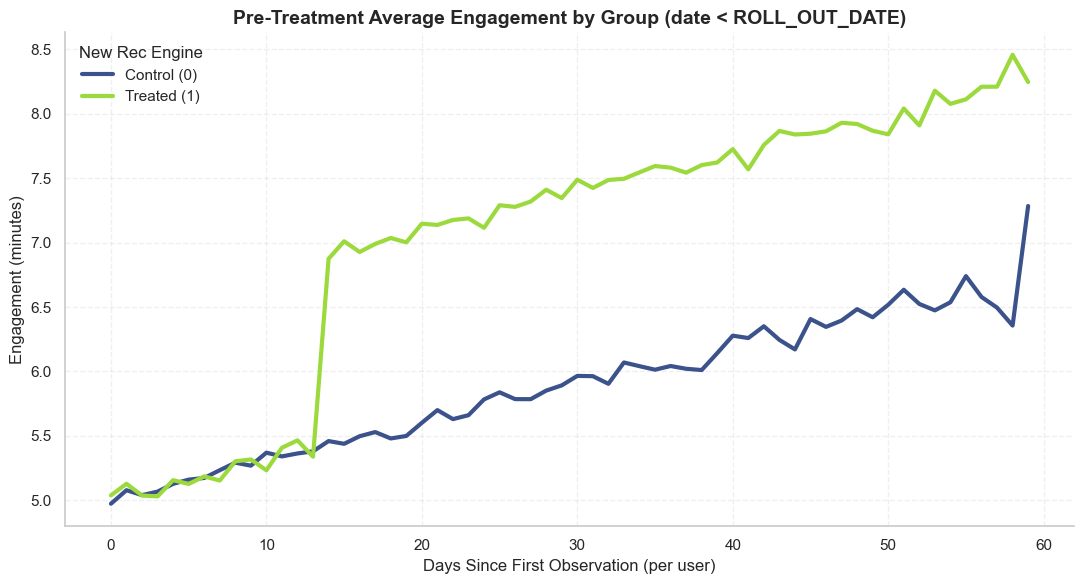

Confirmed: pre-trend figure saved to ../figures/pretrend_means.png


In [53]:
# Aggregate for plotting
df_plot = (
    pre.groupby(["time_idx", "new_rec_engine"])["engagement"]
    .mean()
    .reset_index()
)

# Two contrasting viridis colors: darker for control, brighter for treated
viridis = plt.colormaps["viridis"]
custom_palette = {
    0: viridis(0.25),  # control - dark
    1: viridis(0.85),  # treated - light
}

plt.figure(figsize=(11, 6))

for group in [0, 1]:
    subset = df_plot[df_plot["new_rec_engine"] == group]
    plt.plot(
        subset["time_idx"],
        subset["engagement"],
        label=f"{'Control' if group == 0 else 'Treated'} ({group})",
        color=custom_palette[group],
        linewidth=3
    )

plt.title("Pre-Treatment Average Engagement by Group (date < ROLL_OUT_DATE)", fontsize=14, weight="bold")
plt.xlabel("Days Since First Observation (per user)")
plt.ylabel("Engagement (minutes)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="New Rec Engine", frameon=False)
sns.despine()

# Save high-resolution figure
os.makedirs("../figures", exist_ok=True)
out_path = "../figures/pretrend_means.png"
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confirmed: pre-trend figure saved to {out_path}")

In [54]:

# --- 6) Mixed-effects model on pre-period only ---
# Keep users with >1 pre observations to help identify random intercepts
counts = pre.groupby("user_id").size()
keep_ids = counts[counts > 1].index
pre_m = pre[pre["user_id"].isin(keep_ids)].copy()

# If still too few groups / variance, we fall back to OLS later
print(f"Users with >1 pre obs: {pre_m['user_id'].nunique()}")

# Simple random-intercept model: engagement ~ treatment + (1 | user)
try:
    m = smf.mixedlm("engagement ~ new_rec_engine", data=pre_m, groups=pre_m["user_id"])
    res = m.fit(reml=False)
    print("\nMixedLM (pre-period) summary:")
    print(res.summary())
except Exception as e:
    print(f"\nMixedLM failed ({e}). Falling back to OLS with clustered SEs by user.")
    ols = smf.ols("engagement ~ new_rec_engine", data=pre).fit(
        cov_type="cluster", cov_kwds={"groups": pre["user_id"]}
    )
    print(ols.summary())

Users with >1 pre obs: 1000

MixedLM (pre-period) summary:
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: engagement 
No. Observations: 45060   Method:             ML         
No. Groups:       1000    Scale:              1.8673     
Min. group size:  31      Log-Likelihood:     -78240.0421
Max. group size:  60      Converged:          Yes        
Mean group size:  45.1                                   
---------------------------------------------------------
               Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      5.680    0.011 494.390 0.000  5.657  5.702
new_rec_engine 1.029    0.016  62.884 0.000  0.997  1.061
Group Var      0.025    0.002                            

